In [ ]:
import kwant
import tbmodels
import wraparound
import numpy as np
import scipy.linalg as la
import scipy.sparse.linalg as sla
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from matplotlib import pyplot
import csv
from mayavi.mlab import *
from mayavi import mlab
import mayavi
import math

# Sample model for number of neighbor checks (nn)

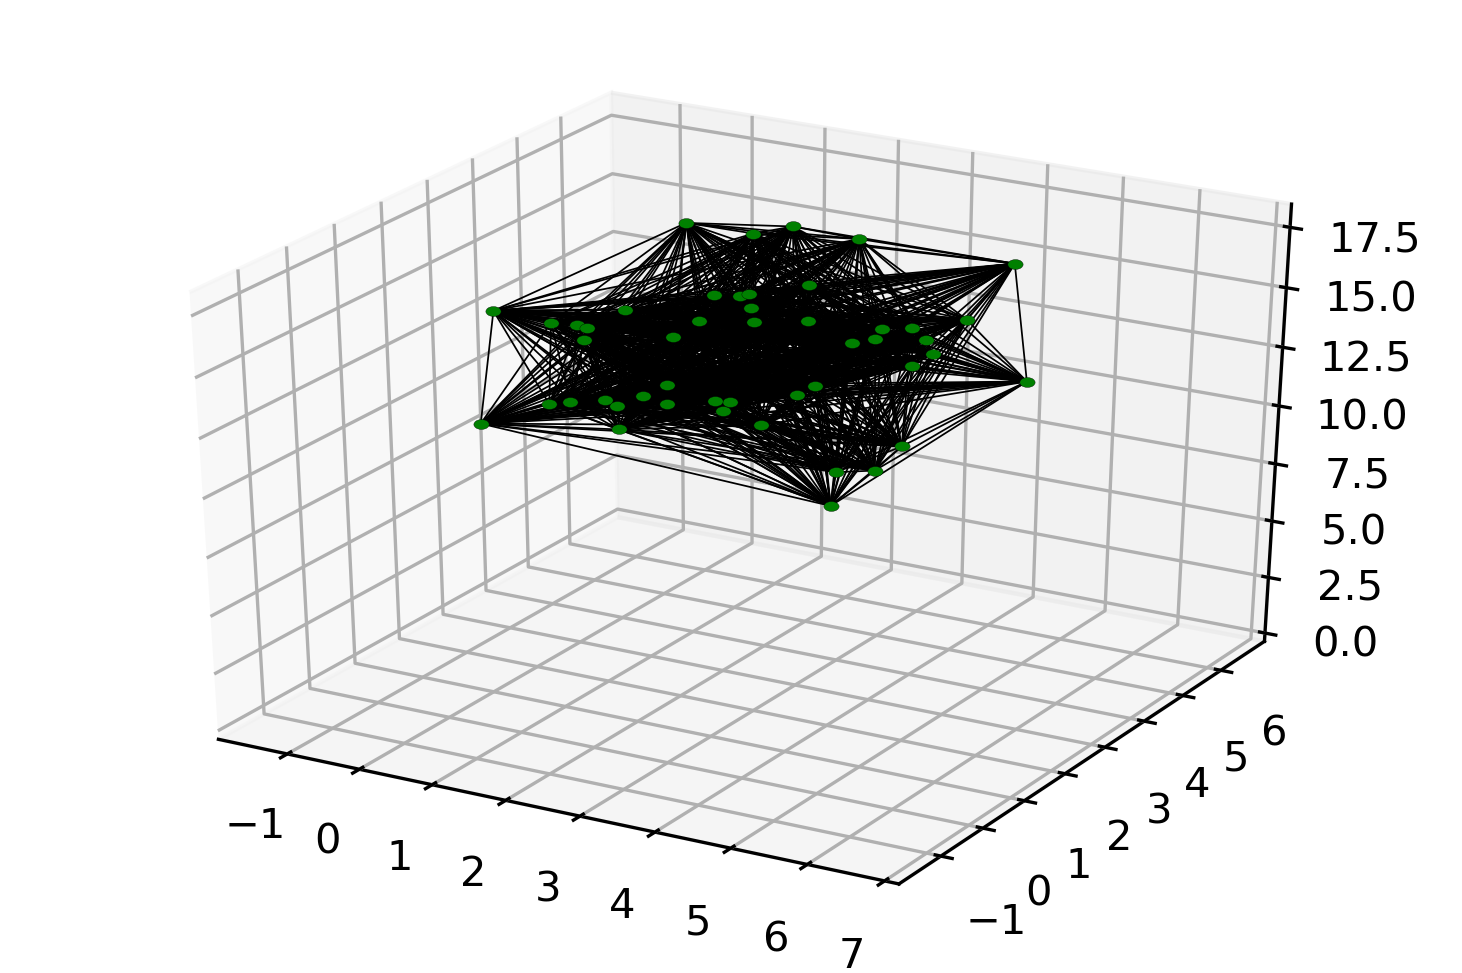

In [2]:
model = tbmodels.Model.from_wannier_files(
	hr_file='BiPentaSi_hr.dat',
	wsvec_file='BiPentaSi_wsvec.dat',
	xyz_file='BiPentaSi_centres.xyz',
	win_file='BiPentaSi.win'
)

nn = 2

remove = [R for R in model.hop if (R[0] > nn) or (R[1] > nn) or (R[2] > nn)]
for R in remove: 
  del model.hop[R]

remove = [R for R in model.hop if (R[0] < -nn) or (R[1] < -nn) or (R[2] < -nn)]
for R in remove: 
  del model.hop[R]

lattice = model.to_kwant_lattice()

def lead_shape(p):
	x, y, z = p
	return -1*model.uc[0][0] < x < 1*model.uc[0][0] and -1*model.uc[1][1] < y < 1*model.uc[1][1] and 0 < z < 30
	
	
sym_lead = kwant.TranslationalSymmetry(
    lattice.vec((1, 0, 0)),
    lattice.vec((0, 1, 0)),
	lattice.vec((0, 0, 1))
)

lead = kwant.Builder(sym_lead)
lead[lattice.shape(lead_shape, (0, 0, 15))] = 0
model.add_hoppings_kwant(lead)

kwant_sys = wraparound.wraparound(lead).finalized()
fig = kwant.plot(kwant_sys, site_size=0.18, site_lw=0.01, hop_lw=0.05, site_color='g', dpi = 300)

# Dispersion curve for 1x1 unit cell in the kx direction

(-3, 3)

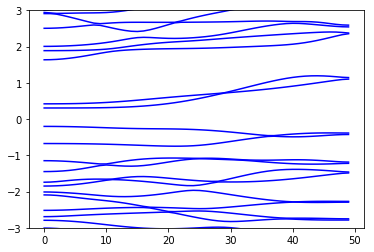

In [3]:
k_list = [(kx, 0, 0) for kx in np.linspace(0, 0.5, 50)]
kx = range(50)
eigs_kwant = [la.eigvalsh(
    kwant_sys.hamiltonian_submatrix(2 * np.pi * np.array(k))
) for k in k_list]
fig, ax = plt.subplots()
for band in np.array(eigs_kwant).T:
    ax.plot(kx, band+1.784, 'b')
plt.ylim(-3,3)

# 6x2 model for transport calculations

Model for nn= 2 created
Lead for nn= 2 created


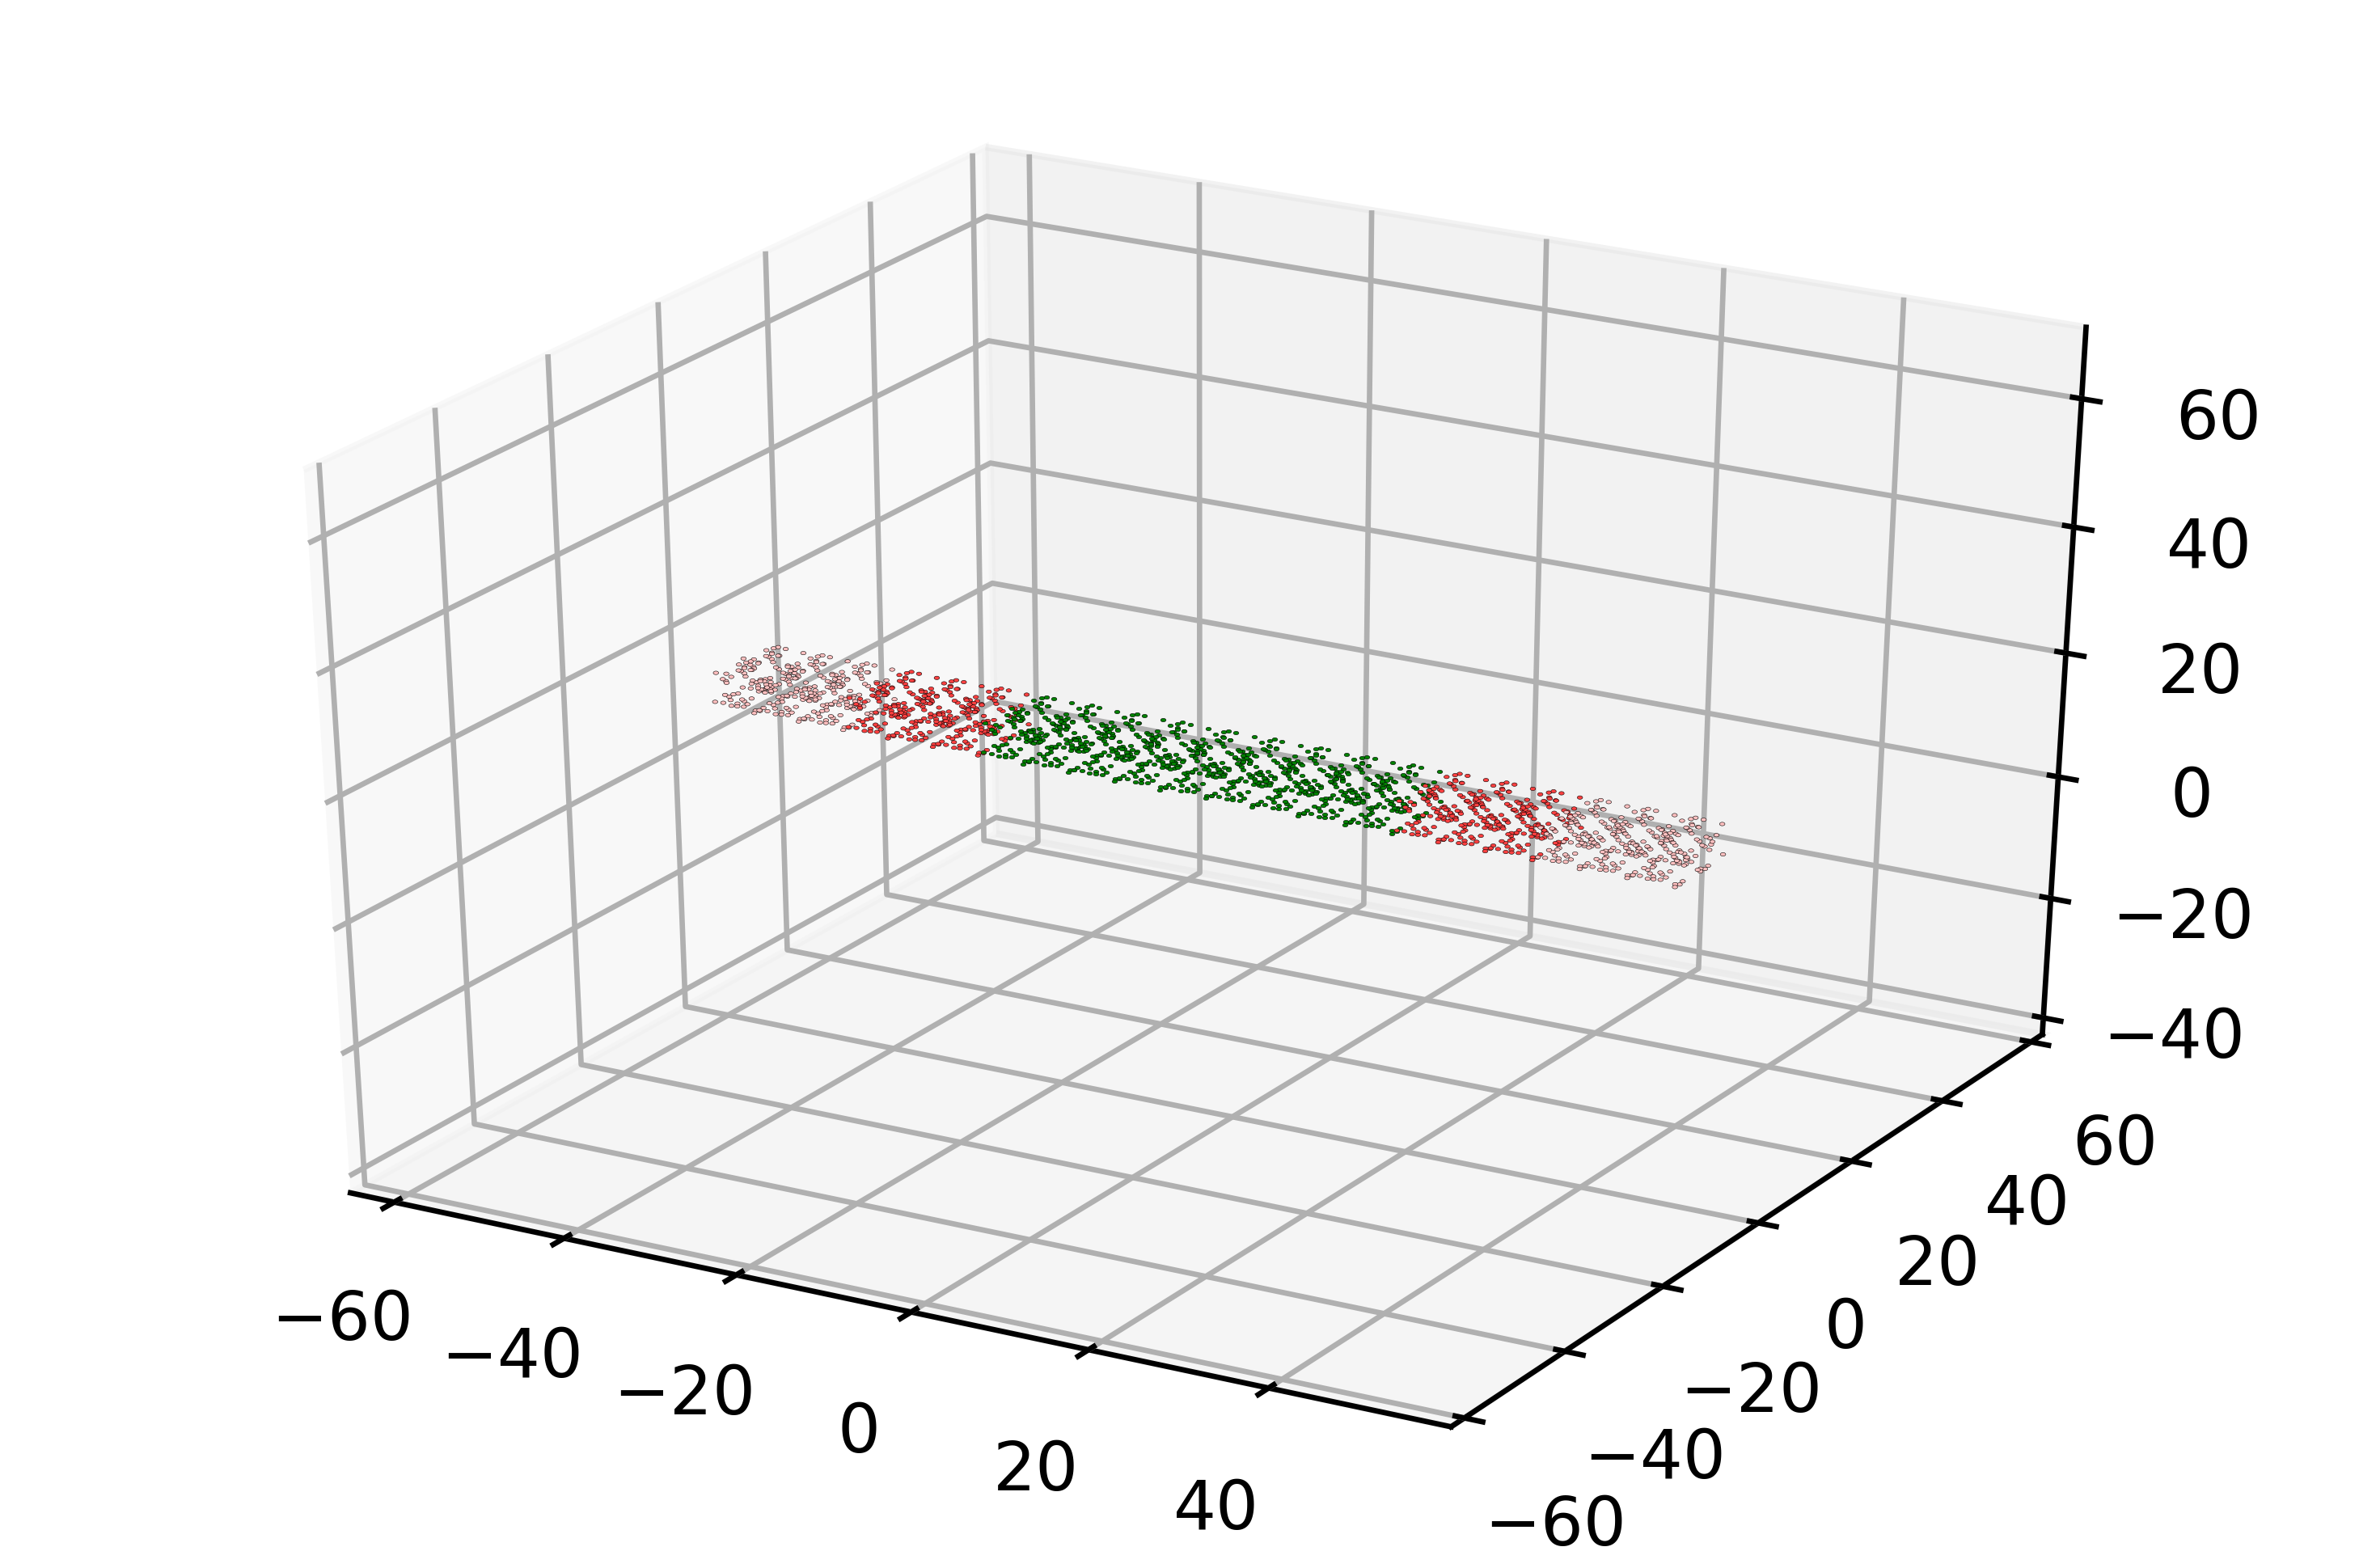

In [4]:
def shape(p):
	x, y, z = p
	return -3*model.uc[0][0] < x < 3*model.uc[0][0] and -1*model.uc[1][1] < y < 1*model.uc[1][1] and 0 < z < 30

def lead_shape(p):
	x, y, z = p
	return -3*model.uc[0][0] < x < 1*model.uc[0][0] and -1*model.uc[1][1] < y < 1*model.uc[1][1] and 0 < z < 30

remove = [R for R in model.hop if (R[0] > nn) or (R[1] > nn) or (R[2] > nn)]
for R in remove: 
  del model.hop[R]

remove = [R for R in model.hop if (R[0] < -nn) or (R[1] < -nn) or (R[2] < -nn)]
for R in remove: 
  del model.hop[R]

lattice = model.to_kwant_lattice()

kwant_model = kwant.Builder()
kwant_model[lattice.shape(shape, (0, 0, 15))] = 0
model.add_hoppings_kwant(kwant_model)

print("Model for nn=",nn,"created")

#1D translational symmetry
sym_lead = kwant.TranslationalSymmetry(
    lattice.vec((-3, 0, 0))
)
lead = kwant.Builder(sym_lead)
lead[lattice.shape(lead_shape, (0, 0, 15))] = 0
model.add_hoppings_kwant(lead)

print("Lead for nn=",nn,"created")

#Add the norbs in the system for plotting of local quantities (current, electron density)
for x in kwant_model.sites():
 x.family.norbs=1

for x in lead.sites():
  x.family.norbs=1

kwant_model.attach_lead(lead)
kwant_model.attach_lead(lead.reversed())
kwant_sys = kwant_model.finalized()

kwant.plot(kwant_sys, site_size=0.5, site_color='g', file='wire-Xdirection.png', dpi = 600)

In [5]:
Ef = -1.784
energies = [i+(Ef-1) for i in np.linspace(0,2,100)]
data = []
for energy in energies:
  print(energy)
  # compute the scattering matrix at a given energy
  try:
    smatrix = kwant.smatrix(kwant_sys, energy)
    data.append(smatrix.transmission(1, 0))
  except RuntimeError:
   print("Error")
   continue

-2.784
-2.7637979797979795
-2.7435959595959596
-2.7233939393939393
-2.703191919191919
-2.6829898989898986
-2.6627878787878787
-2.6425858585858584
-2.622383838383838
-2.602181818181818
-2.581979797979798
-2.5617777777777775
-2.5415757575757576
-2.5213737373737373
-2.501171717171717
-2.4809696969696966
-2.4607676767676767
-2.4405656565656564
-2.420363636363636
-2.4001616161616157
-2.379959595959596
-2.3597575757575755
-2.339555555555555
-2.3193535353535353
-2.299151515151515
-2.2789494949494946
-2.2587474747474747
-2.2385454545454544
-2.218343434343434
-2.198141414141414
-2.177939393939394
-2.1577373737373735
-2.137535353535353
-2.117333333333333
-2.097131313131313
-2.0769292929292926
-2.0567272727272723
-2.0365252525252524
-2.016323232323232
-1.9961212121212117
-1.9759191919191916
-1.9557171717171715
-1.9355151515151512
-1.915313131313131
-1.895111111111111
-1.8749090909090906
-1.8547070707070703
-1.8345050505050502
-1.81430303030303
-1.7941010101010098
-1.7738989898989896
-1.7536969696

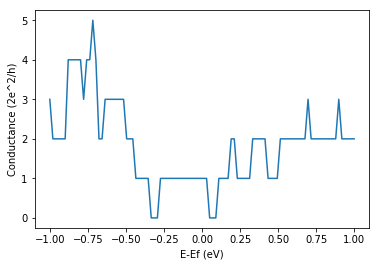

In [6]:
pyplot.figure()
energies = np.array(energies)
pyplot.plot(energies-Ef, data)
pyplot.xlabel("E-Ef (eV)")
pyplot.ylabel("Conductance (2e^2/h)")
pyplot.show()

# 2D current plot at the z location of Si7 and Si8 (zcut=35) at the energy where their ldos is at its maximum

In [7]:
for x in kwant_model.sites():
  x.family.norbs=1

for x in lead.sites():
  x.family.norbs=1

kwant_model.attach_lead(lead)
kwant_model.attach_lead(lead.reversed())
kwant_sys = kwant_model.finalized()

energy = Ef-0.191919
#-1.97591919
psi = kwant.wave_function(kwant_sys, energy=energy)
J = kwant.operator.Current(kwant_sys)
all_states = np.vstack(psi(0))
current = sum(J(p) for p in all_states)
curr_i = kwant.plotter.interpolate_current(kwant_sys,current)

1


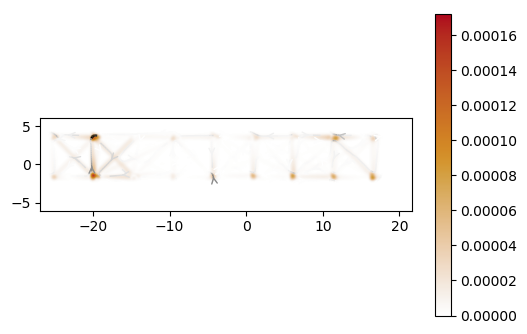

2


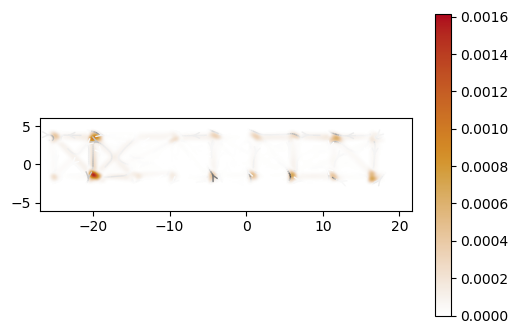

3


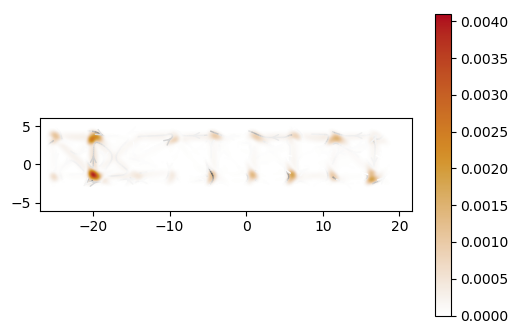

4


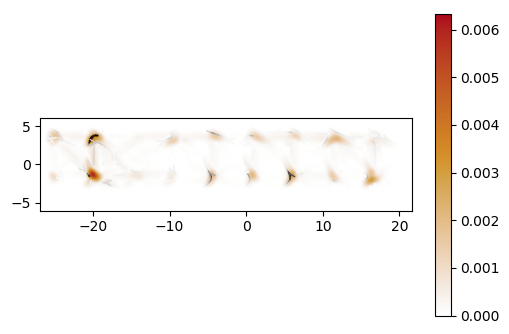

5


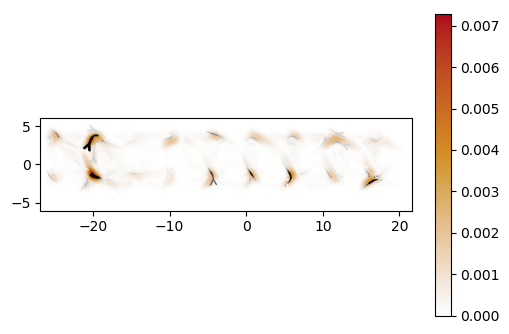

6


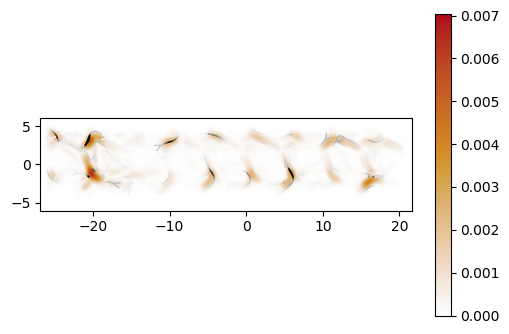

7


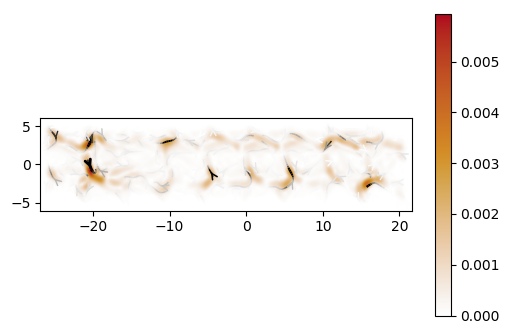

8


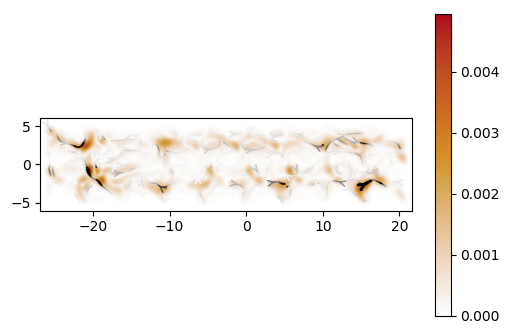

9


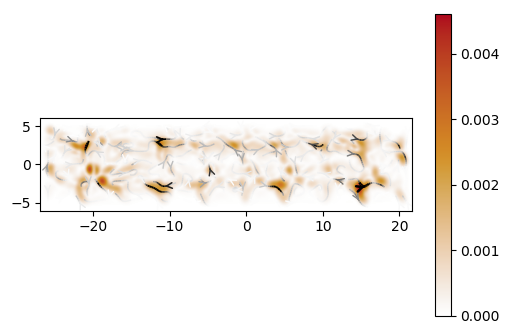

10


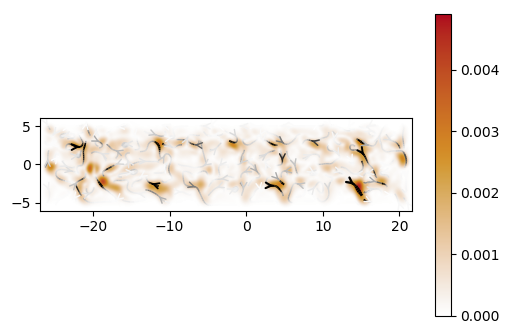

11


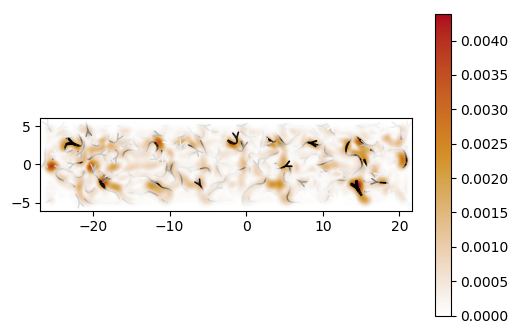

12


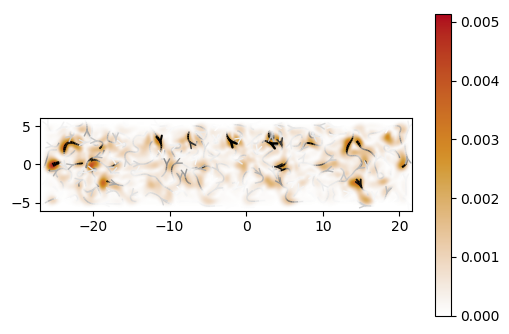

13


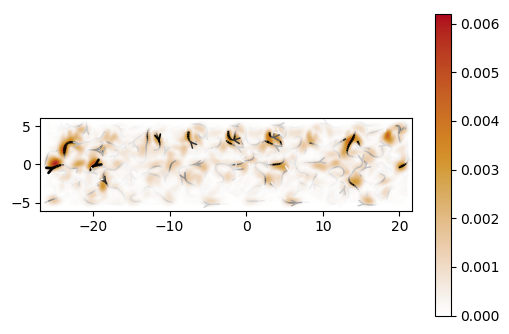

14


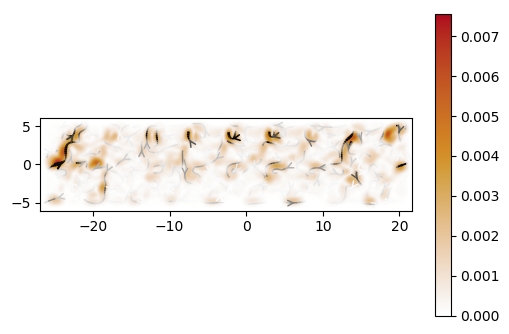

15


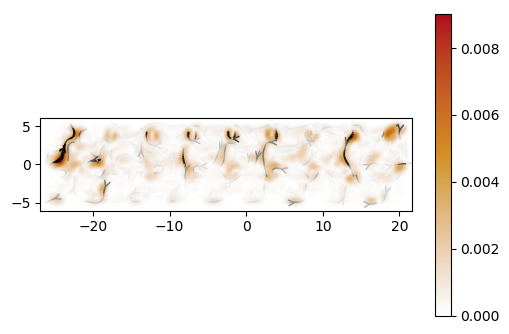

16


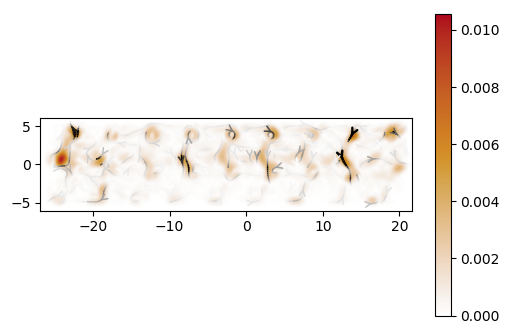

17


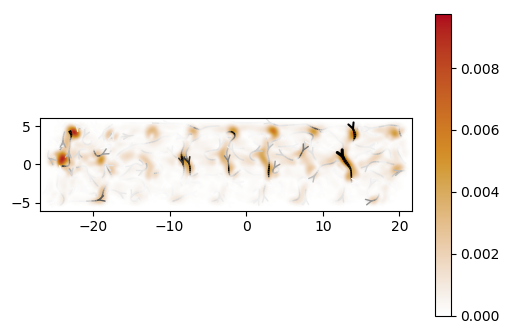

18


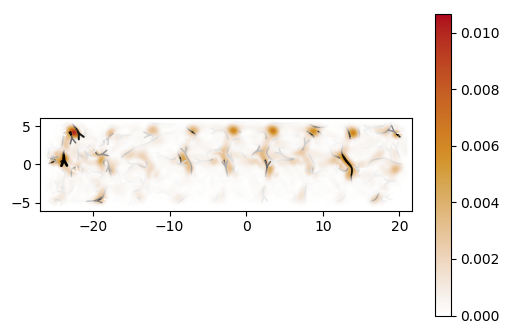

19


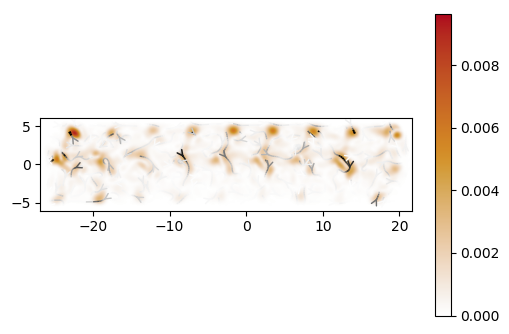

20


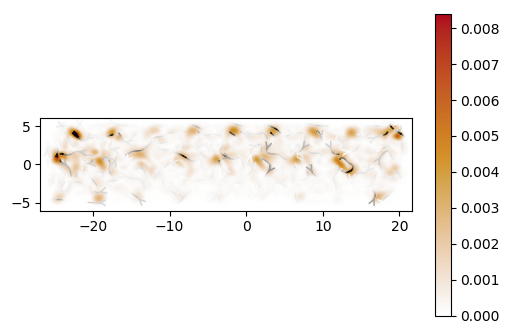

21


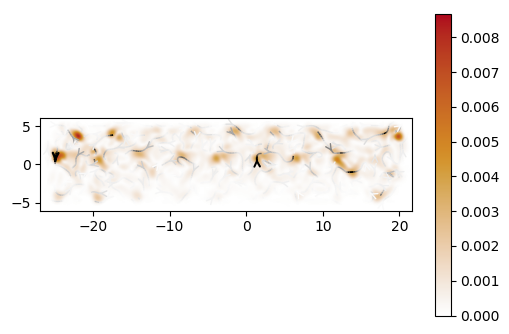

22


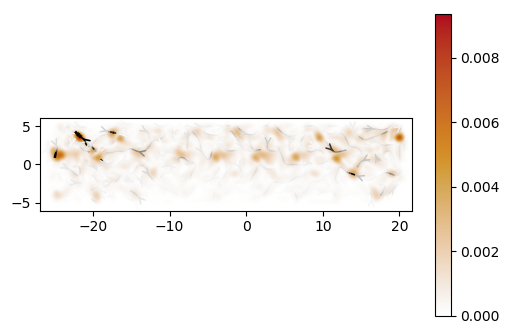

23


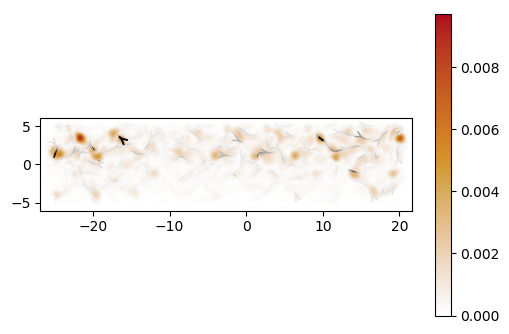

24


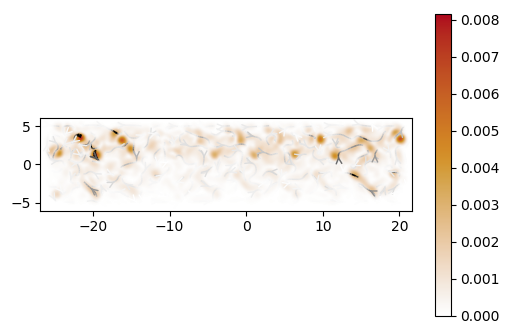

25


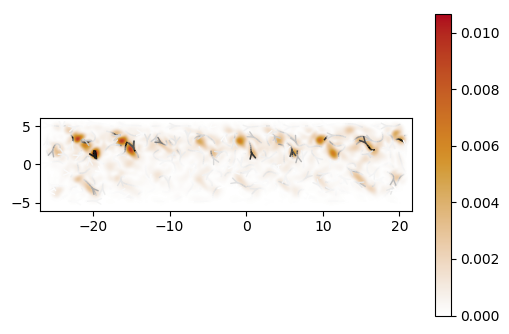

26


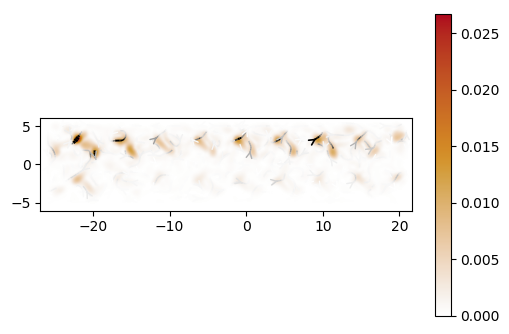

27


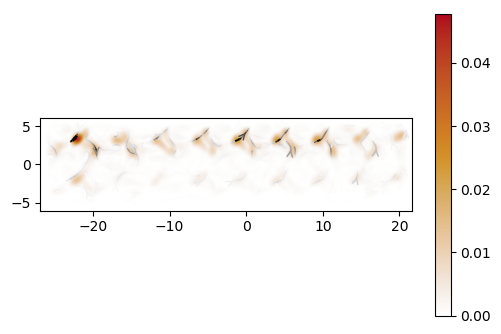

28


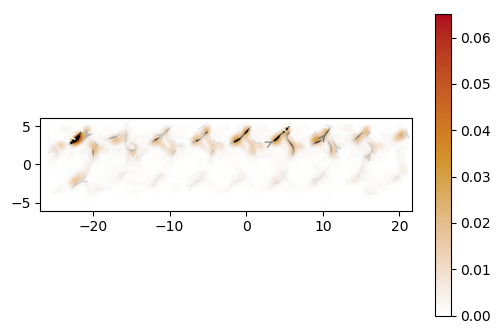

29


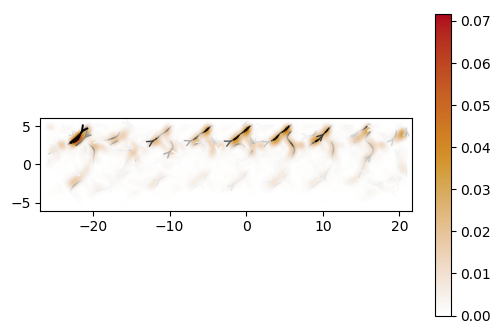

30


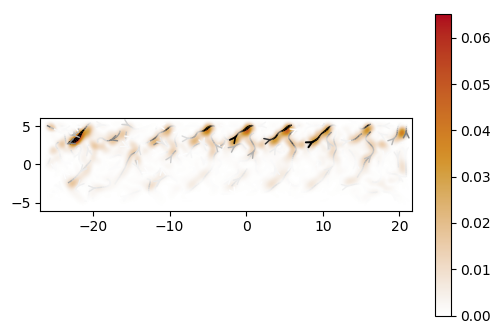

31


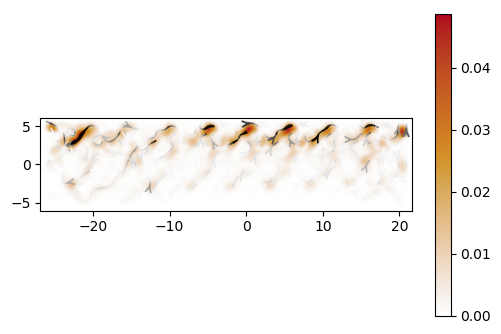

32


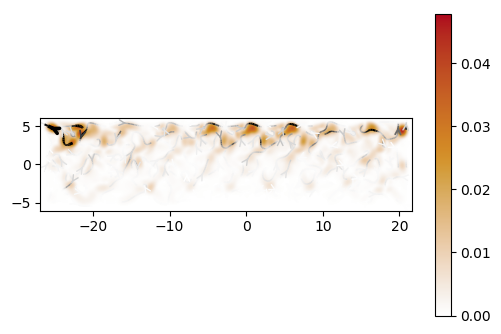

33


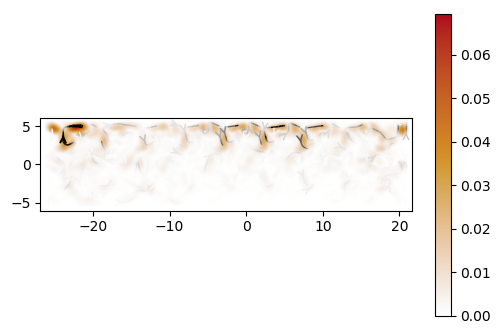

34


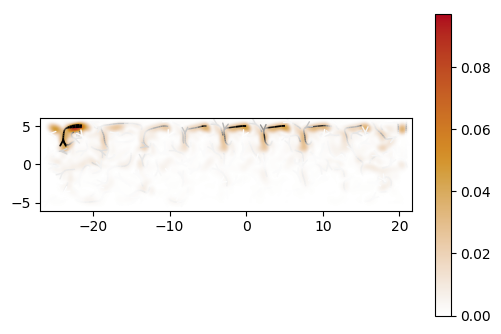

35


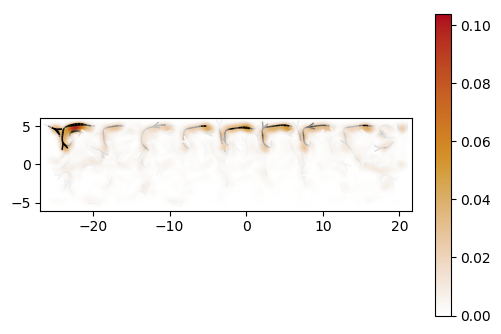

36


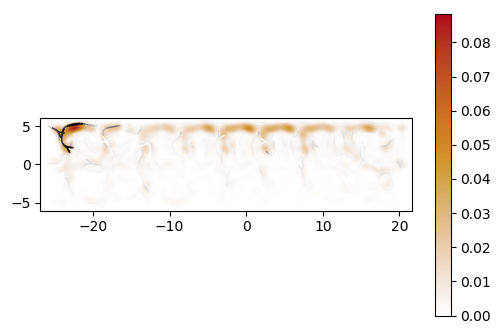

37


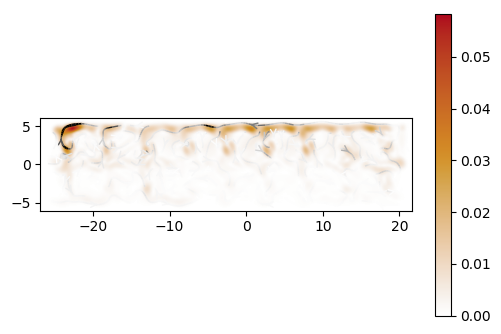

38


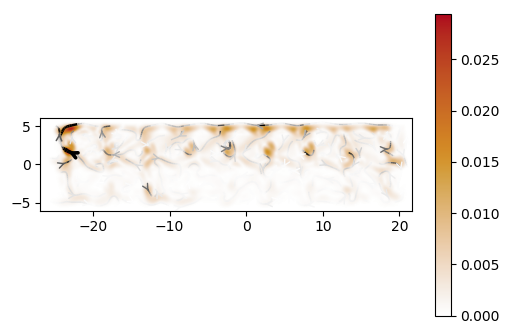

39


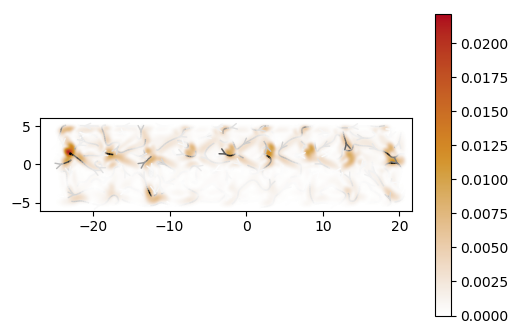

40


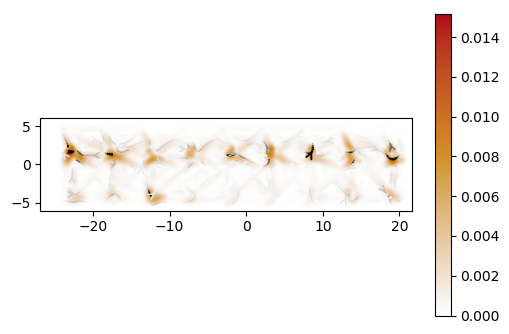

41


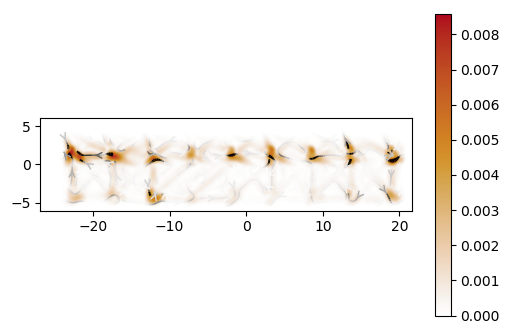

42


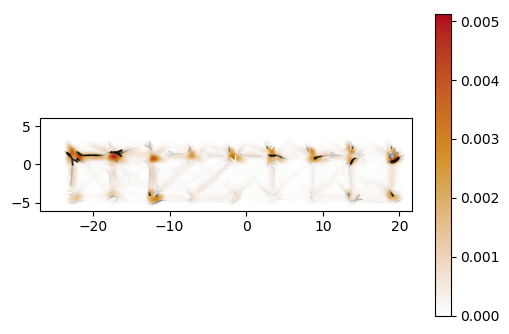

43


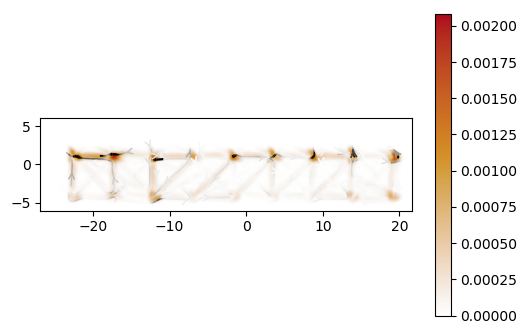

44


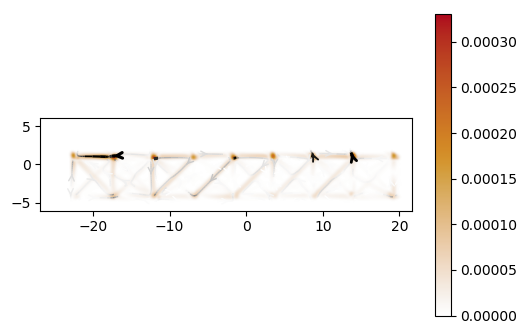

In [9]:
for zcut in range(1,45):
  print(zcut)
  kwant.plotter.streamplot(curr_i[0][:,:,zcut,:2], (curr_i[1][0],curr_i[1][1]),dpi=100)